In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [2]:
alcohol_data = pd.read_csv("./data/BeerWineLiquor.csv")

##### Data Exploration

In [4]:
alcohol_data.shape

(324, 2)

In [6]:
alcohol_data.isna().sum()

date    0
beer    0
dtype: int64

In [3]:
alcohol_data.head()

,date,beer
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822


In [7]:
alcohol_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    324 non-null    object
 1   beer    324 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.2+ KB


In [8]:
alcohol_data["date"] = pd.to_datetime(alcohol_data["date"])

In [10]:
alcohol_data.set_index("date", inplace=True)

##### Data Visualization

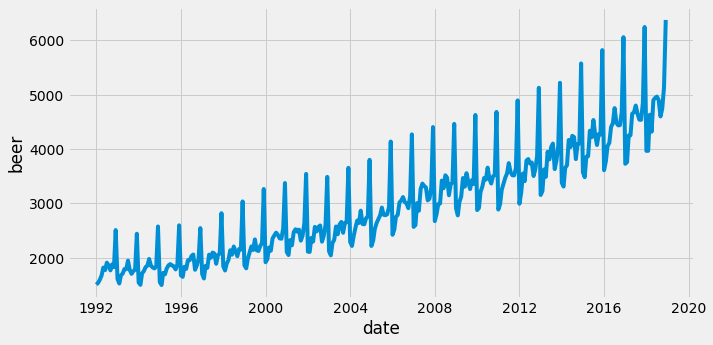

In [22]:
plt.figure(figsize=(10,5))
sns.lineplot(alcohol_data.index, "beer", data=alcohol_data)

From the above plot we can conclude that the data consists of trend and seasonality.

In [23]:
def create_features(df, label=None):
    """
    Ref: https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet
    
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [27]:
X, y = create_features(alcohol_data, label='beer')

alcohol_data_features = pd.concat([X, y], axis=1)

In [28]:
alcohol_data_features.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,beer
date,,,,,,,,,
1992-01-01,0,2,1,1,1992,1,1,1,1509
1992-02-01,0,5,1,2,1992,32,1,5,1541
1992-03-01,0,6,1,3,1992,61,1,9,1597
1992-04-01,0,2,2,4,1992,92,1,14,1675
1992-05-01,0,4,2,5,1992,122,1,18,1822


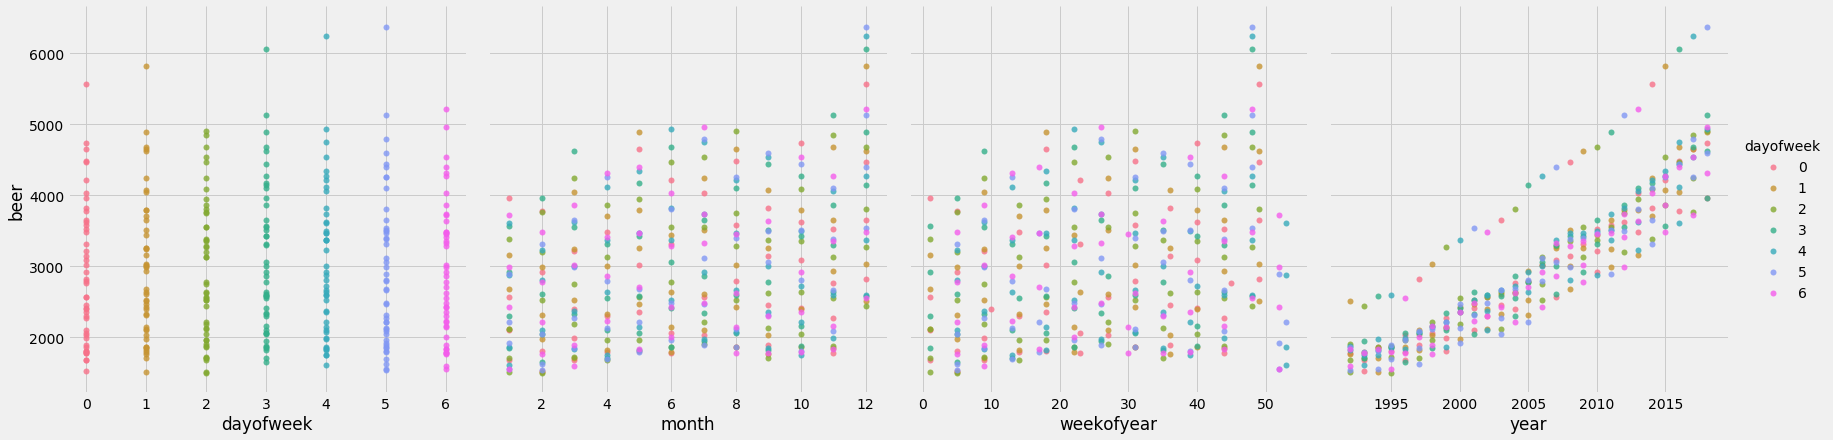

In [35]:
sns.pairplot(alcohol_data_features.dropna(),
             hue='dayofweek',
             x_vars=['dayofweek', 'month',
                     'weekofyear', 'year'],
             y_vars='beer',
             height=6,
             plot_kws={'alpha':0.8, 'linewidth':0}
            )
# plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
plt.show()

The seasionality in the data can be further confirmed with the `month` plot. We see the sales of the alcohol is much higher in december indicating that more alcohol is consumed during the holiday season. The same is observed in the final weeks of the year in the `week_of_year` plot.

##### Check for Stationarity

Visually it can be confirmed that the time series is not stationary, since it has an increasing trend the mean of the time series is time dependant and not constant. 

Augmented Dickey-Fuller test can be performed on the data to confirm the lack of stationarity with a statistic.

In [38]:
from statsmodels.tsa.stattools import adfuller

In [41]:
class StationarityTests:
    """
    Ref: https://www.hackdeploy.com/augmented-dickey-fuller-test-in-python/
    """
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]

        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False

        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [42]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(alcohol_data["beer"], printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        2.864309
P-Value                   1.000000
# Lags Used              15.000000
# Observations Used     308.000000
Critical Value (1%)      -3.451761
Critical Value (5%)      -2.870970
Critical Value (10%)     -2.571794
dtype: float64
Is the time series stationary? False


Since the P-value is greater than the significance level, we can conclude that the time series is non-stationary. The next step is to make the time series stationary in order to use ARIMA model for forecasting.

#### Differencing
One approach to make the time series a stationary time-series is by differencing i.e. taking a difference of the current value with a previous value of a certain lag.

In [43]:
# Difference with a lag of 1
alcohol_data["First_difference"] = alcohol_data["beer"] - alcohol_data["beer"].shift(1) 

In [45]:
# Difference with a lag of 12, since we have seasionality
alcohol_data["Seasonal_difference"] = alcohol_data["beer"] - alcohol_data["beer"].shift(12)

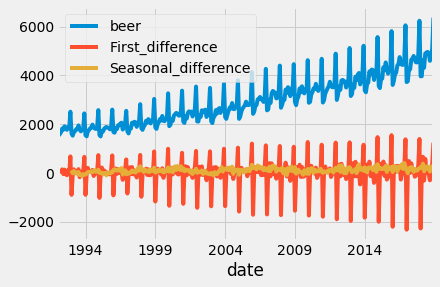

In [46]:
alcohol_data.plot()

##### Selecting AR and MA parameters for ARIMA model

* AR parameter is selected with a PACF (Partial Autocorrelation Function)
    * The point where there is a "shut off" i.e. a sudden drop to zero or close to zero is considered.
* MA parameter is selected with a ACF (Autocorrelation Function)
    * The point where the graph tends towards zero is selected.

In [52]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

D:\Users\prana\Anaconda3\envs\Python3.7\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


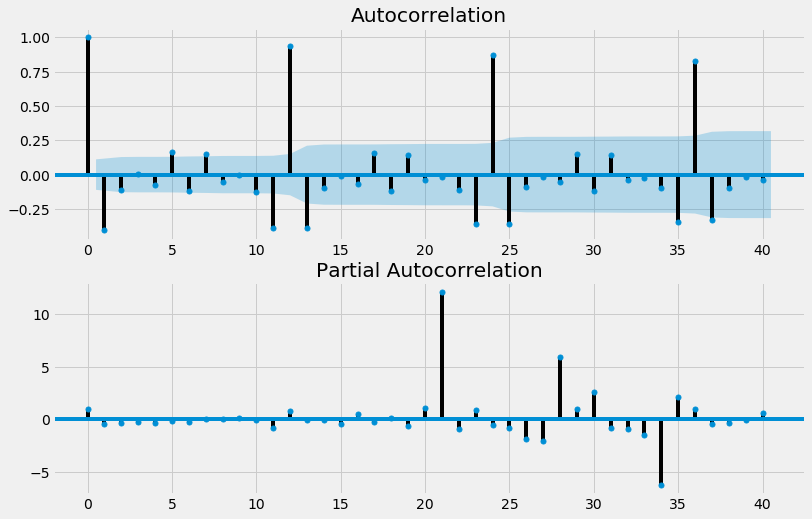

In [53]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(alcohol_data['First_difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(alcohol_data['First_difference'].iloc[13:],lags=40,ax=ax2)

Therefore, from PCAF, for AR - p = 1, for MA - q = 0 or 1, I - d = 1 (since first difference is plotted)

#### ARIMA

In [56]:
from statsmodels.tsa.arima_model import ARIMA

In [66]:
model = ARIMA(alcohol_data["beer"],order=(1,1,0))
model_fit = model.fit()

D:\Users\prana\Anaconda3\envs\Python3.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Users\prana\Anaconda3\envs\Python3.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [67]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.beer   No. Observations:                  323
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2480.338
Method:                       css-mle   S.D. of innovations            523.137
Date:                Sun, 27 Sep 2020   AIC                           4966.677
Time:                        20:58:01   BIC                           4978.010
Sample:                    02-01-1992   HQIC                          4971.201
                         - 12-01-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           13.8966     20.666      0.672      0.501     -26.608      54.401
ar.L1.D.beer    -0.4098      0.051     -8.027      0.000      -0.510      -0.310
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.4403           +0.0000j            2.4403            0.5000
-----------------------------------------------------------------------------
"""

In [68]:
alcohol_data.shape

(324, 4)

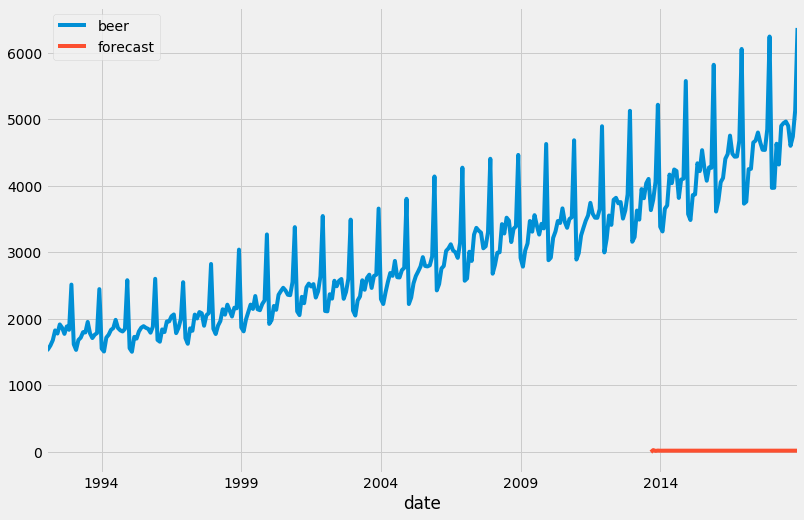

In [69]:
alcohol_data['forecast'] = model_fit.predict(start=260,end=324,dynamic=True)
alcohol_data[['beer','forecast']].plot(figsize=(12,8))

The predictions are bad since the differencing is one i.e. without considering seasionality.

#### SARIMAX

The SARIMAX model considers the seasonality factor in the dataset, which can be specified with the help of the seasonal order parameter.

In [85]:
model = sm.tsa.statespace.SARIMAX(alcohol_data['beer'],order=(1, 1, 1), seasonal_order=(1,1,1,12))
results = model.fit()

D:\Users\prana\Anaconda3\envs\Python3.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
D:\Users\prana\Anaconda3\envs\Python3.7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


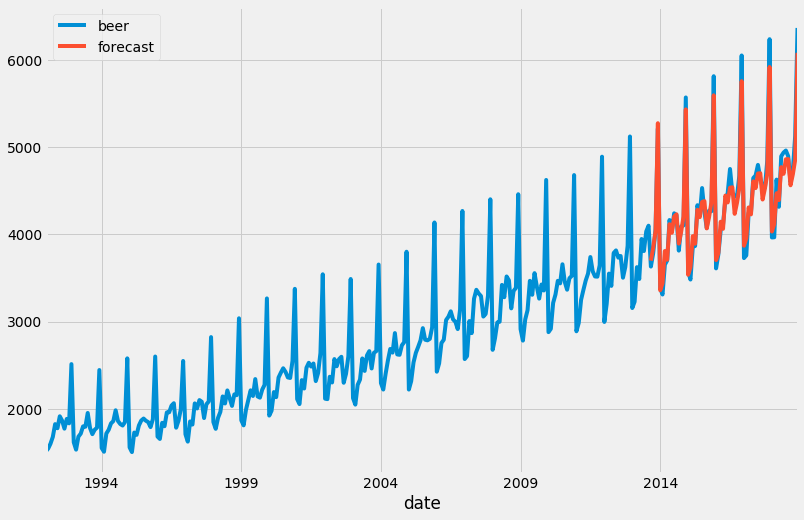

In [86]:
alcohol_data['forecast']=results.predict(start=260,end=324,dynamic=True)
alcohol_data[['beer','forecast']].plot(figsize=(12,8))

##### Evaluating predictions

In [87]:
alcohol_data.head()

,beer,First_difference,Seasonal_difference,forecast
date,,,,
1992-01-01,1509,NaN,NaN,NaN
1992-02-01,1541,32.0,NaN,NaN
1992-03-01,1597,56.0,NaN,NaN
1992-04-01,1675,78.0,NaN,NaN
1992-05-01,1822,147.0,NaN,NaN


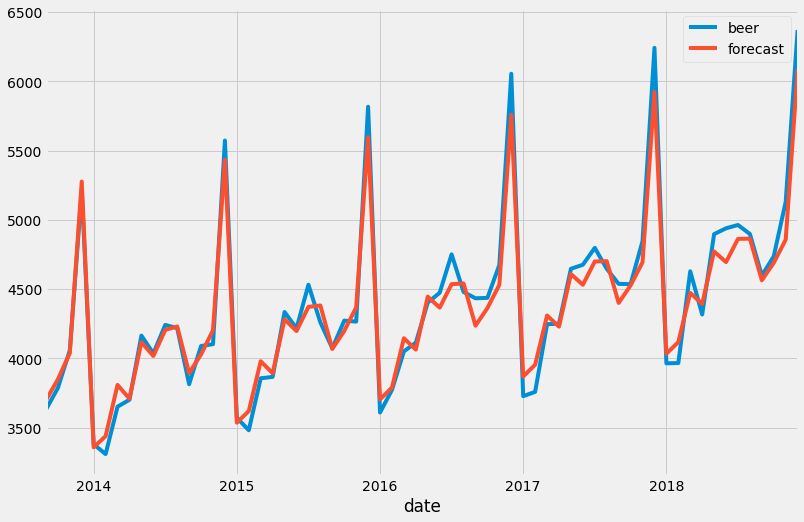

In [90]:
alcohol_data.iloc[260:,:][['beer','forecast']].plot(figsize=(12,8))

In [89]:
y_true = alcohol_data.iloc[260:,:]["beer"]
y_pred = alcohol_data.iloc[260:,:]["forecast"]

In [91]:
from sklearn.metrics import mean_absolute_error

In [92]:
print("MAE - ", mean_absolute_error(y_true, y_pred))

MAE -  100.93226943377675


##### Predictions into future

In [79]:
from pandas.tseries.offsets import DateOffset

future_dates = [alcohol_data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [80]:
alcohol_data_future = pd.DataFrame(index=future_dates[1:],columns=alcohol_data.columns)

In [81]:
alcohol_data_future = pd.concat([alcohol_data, alcohol_data_future])

In [82]:
alcohol_data_future.shape

(347, 4)

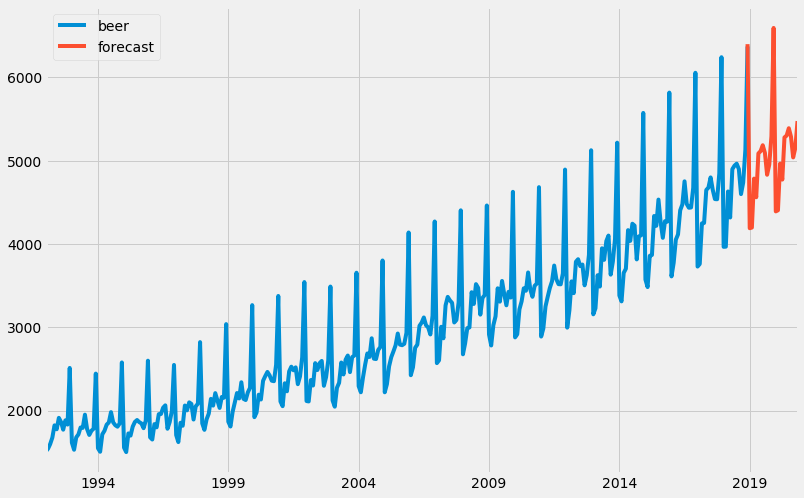

In [84]:
alcohol_data_future['forecast'] = results.predict(start = 323, end = 347, dynamic= True)  
alcohol_data_future[['beer', 'forecast']].plot(figsize=(12, 8))

The SARIMAX model has learnt the trend and seasionality in the model and the future predictions are promissing.